In [1]:
!pip install komm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56608 sha256=ea88c3caf8eaf194e715a6198f2c592077fc32f2d0a788269f4a3f2deae958c5
  Stored in directory: /root/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built komm


In [2]:
from logging import Filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy as scy
import komm


from tokenize import Number
from numpy import pi
from numpy import sin
from numpy import cos
from numpy import r_
from numpy import random as rm
from scipy.signal import butter, lfilter
from scipy.fftpack import fft



# Helper
def butterLowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Filter data that is sampled at fs using a low pass butterworth filter of order filt_order
def butterLowpassFilter(data, cutoff, fs, filt_order=5):
    b, a = butterLowpass(cutoff, fs, order=filt_order)
    y = lfilter(b, a, data)
    return y





# Base waveforms
def genSineWave(fc, fs, Ns, plotDebug=False):
    """
    Generates a sine wave with the specified parameters:
    carrier frequency fc, 
    sampling frequency fs, 
    Number of samples Ns
    
    Optional debug flag plotDebug
    """

    offset = rm.randint(0,1000)
    t = r_[0.0+offset:Ns+offset]/fs            # time points
    
    carrier = cos(2*pi*fc*t) 

    SineWave = carrier

    if plotDebug:
        plt.plot(carrier)
        plt.show()

    return SineWave

def genBPSK(fc, fs, Ns, SymbolRate, printDebug=False, plotDebug=False):
    """
    Generate samples of BPSK with the specified parameters:
    carrier frequency fc, 
    sampling frequency fs,
    Number of samples Ns,
    Symbol rate Symbolrate
    
    Optional debug flags printDebug and plotDebug
    """
    NsSymbol = fs/SymbolRate 
    NbitsBPSK = int(np.ceil(Ns / NsSymbol))

    if printDebug:
        print("BPSK samples: ", Ns)
    
    offset = rm.randint(0,1000)
    t = r_[0.0+offset:Ns+offset]/fs            # time points
    inputBits = np.random.randn(NbitsBPSK,1) > 0 
    carrier = cos(2*pi*fc*t)

    I_bits= np.asarray(inputBits)
    if printDebug:
        print(I_bits)

    start = 0

    I_signal = []
    I_index =  0
    NextSymbolTime = NsSymbol

    I_bits = I_bits *2 - 1
    
    while start < Ns:
        I_signal.append(I_bits[I_index])
        start = start + 1
        if start > NextSymbolTime:
            I_index = I_index + 1
            NextSymbolTime = NextSymbolTime + NsSymbol


    I_signal = np.array(I_signal).ravel()

    rrc = komm.RootRaisedCosinePulse(0.4, 10)
    symbol_array = np.arange(-10.5 , 10.5, 1/NsSymbol)
    if plotDebug:
        plt.plot(symbol_array)
        plt.show()
    rrc_response = np.empty([len(symbol_array)])
    o = 0
    for i in symbol_array:
        rrc_response[o] = rrc.impulse_response(i)
        o=o + 1
    if plotDebug:
        plt.plot(rrc_response)
        plt.show()
    I_signal_pulse = np.convolve(I_signal,rrc_response)
    I_signal_pulse = I_signal_pulse[int(len(rrc_response)/2):len(I_signal_pulse)-int(len(rrc_response)/2) + (len(rrc_response)+1) % 2]
    if plotDebug:
        plt.plot(I_signal_pulse)
        plt.show()
    BPSK_Signal = I_signal_pulse * carrier
    BPSK_Signal = BPSK_Signal / max(abs(BPSK_Signal))
    if plotDebug:
        plt.plot(BPSK_Signal)
        plt.show()

    if plotDebug: 
        fig, axis = plt.subplots(2,1,sharex='col')
        fig.suptitle('BPSK Signal', fontsize=12)
        axis[0].plot(t,BPSK_Signal, color='C1')
        axis[1].plot(t,I_signal, color='C2')
        plt.subplots_adjust(hspace=0.5)
        plt.show()
    return BPSK_Signal

def genQPSK(fc, fs, Ns, SymbolRate, printDebug=False, plotDebug=False):
    """
    Generate samples of QPSK with the specified parameters:
    carrier frequency fc, 
    sampling frequency fs,
    Number of samples Ns,
    Symbol rate Symbolrate
    
    Optional debug flags printDebug and plotDebug
    """
    NsSymbol = fs/SymbolRate
    NbitsQPSK = int(np.ceil(Ns / NsSymbol)) * 2

    offset = rm.randint(0,1000)
    t = r_[0.0+offset:Ns+offset]/fs            # time points
    if printDebug:
        print("QPSK samples: ", Ns)
    # Input of the modulator
    inputBits = np.random.randn(NbitsQPSK,1) > 0 

    # Carrier signals used for modulation.
    carrier1 = cos(2*pi*fc*t)
    carrier2 = sin(2*pi*fc*t)

    I_bits = inputBits[::2]
    Q_bits = inputBits[1::2]





    
    start = 0

    I_signal = []
    I_index =  0
    NextSymbolTime = NsSymbol

    I_bits = I_bits *2 - 1
    
    while start < Ns:
        I_signal.append(I_bits[I_index])
        start = start + 1
        if start > NextSymbolTime:
            I_index = I_index + 1
            NextSymbolTime = NextSymbolTime + NsSymbol


    I_signal = np.array(I_signal).ravel()



    
    start = 0
    Q_signal = []
    Q_index =  0
    NextSymbolTime = NsSymbol

    Q_bits = Q_bits *2 - 1
    
    while start < Ns:
        Q_signal.append(Q_bits[Q_index])
        start = start + 1
        if start > NextSymbolTime:
            Q_index = Q_index + 1
            NextSymbolTime = NextSymbolTime + NsSymbol


    Q_signal = np.array(Q_signal).ravel()







    # I_signal = (np.tile(I_bits*2-1,(1,int(NsSymbol)))).ravel()
    # Q_signal = (np.tile(Q_bits*2-1,(1,int(NsSymbol)))).ravel()
    
    rrc = komm.RootRaisedCosinePulse(0.4, 10)
    symbol_array = np.arange(-10.5 , 10.5, 1/NsSymbol)
    rrc_response = np.empty([len(symbol_array)])
    if plotDebug:
        plt.plot(symbol_array)
        plt.show()
    o = 0
    for i in symbol_array:
        # print(o)
        # print(rrc.impulse_response(i))
        rrc_response[o] = rrc.impulse_response(i)
        o=o + 1
        
    if plotDebug:
        plt.plot(rrc_response)
        plt.show()

    I_signal_pulse = np.convolve(I_signal, rrc_response)
    Q_signal_pulse = np.convolve(Q_signal, rrc_response)
    I_signal_pulse = I_signal_pulse[int(len(rrc_response)/2):len(I_signal_pulse)-int(len(rrc_response)/2) + (len(rrc_response)+1) % 2]
    Q_signal_pulse = Q_signal_pulse[int(len(rrc_response)/2):len(Q_signal_pulse)-int(len(rrc_response)/2) + (len(rrc_response)+1) % 2]
    if plotDebug:
        plt.plot(I_signal_pulse)
        plt.plot(Q_signal_pulse)
        plt.show()
    
    I_signal_modulated = I_signal_pulse * carrier1
    Q_signal_modulated = Q_signal_pulse * carrier2

    QPSK_signal = I_signal_modulated + Q_signal_modulated

    QPSK_signal = QPSK_signal / max(abs(QPSK_signal))

    if plotDebug:
        fig, axis = plt.subplots(3,1,sharex='col')
        fig.suptitle('QPSK Signal', fontsize=12)
        axis[0].plot(t,QPSK_signal, color='C1')
        axis[1].plot(t,I_signal, color='C2')
        axis[2].plot(t,Q_signal, color='C3')
        plt.subplots_adjust(hspace=0.5)
        
        plt.show()
    return QPSK_signal

# Noise added to base waveforms
def genSineWaveNoise(SNR, fc=75000, fs=2048000, Ns=500, plotDebug=False):

    
    """
    Generates a noisy sine wave with the specified parameters:
    Signal-Noise Ratio SNR,
    carrier frequency fc, 
    sampling frequency fs, 
    Number of samples Ns
    
    Optional debug flag plotDebug
    """

    SineWave = genSineWave(fc,fs,Ns)
    SNRRandRange = SNR - 0.5 + rm.random()
    SNRLin = pow(10, SNRRandRange/10)
    SigPower = np.linalg.norm(SineWave)**2 / SineWave.size
    awgn = komm.AWGNChannel(SNRLin, SigPower)
    SineWave_Noise = awgn(SineWave)
    SineWave_NoiseNormal = SineWave_Noise/max(abs(SineWave_Noise))
    if plotDebug:
        plt.plot(SineWave_NoiseNormal)
        plt.show()
    return SineWave_NoiseNormal

def genBPSKNoise(SNR, fc, fs, Ns, SymbolRate, printDebug=False, plotDebug=False):
    """
    Generates a noisy BSPK wave with the specified parameters:
    Signal-Noise Ratio SNR,
    carrier frequency fc, 
    sampling frequency fs, 
    Number of samples Ns,
    Symbol Rate SymbolRate
    
    Optional debug flags printDebug plotDebug
    """
    BPSK = genBPSK(fc,fs,Ns,SymbolRate)
    
    SNRRandRange = SNR - 0.5 + rm.random()
    SNRLin = pow(10, SNRRandRange/10)
    SigPower = np.linalg.norm(BPSK)**2 / BPSK.size
    awgn = komm.AWGNChannel(SNRLin, SigPower)
    BPSK_Noise = awgn(BPSK)

    BPSK_NoiseNormal = BPSK_Noise/max(abs(BPSK_Noise))

    
    if plotDebug:
        plt.plot(BPSK)
        plt.plot(BPSK_Noise)
        plt.show()
    
    
    return BPSK_NoiseNormal

def genQPSKNoise(SNR, fc, fs, Ns, SymbolRate, printDebug=False, plotDebug=False):
    """
    Generates a noisy QSPK wave with the specified parameters:
    Signal-Noise Ratio SNR,
    carrier frequency fc, 
    sampling frequency fs, 
    Number of samples Ns,
    Symbol Rate SymbolRate
    
    Optional debug flags printDebug plotDebug
    """
    
    QPSK = genQPSK(fc, fs, Ns, SymbolRate)
    SNRRandRange = SNR - 0.5 + rm.random()
    SNRLin = pow(10, SNRRandRange/10)
    SigPower = np.linalg.norm(QPSK)**2 / QPSK.size
    awgn = komm.AWGNChannel(SNRLin, SigPower)
    QPSK_Noise = awgn(QPSK)

    QPSK_NoiseNormal = QPSK_Noise/max(abs(QPSK_Noise))

    
    if plotDebug:
        # plt.plot(QPSK)
        # plt.plot(QPSK_NoiseNormal)
        plt.plot(QPSK)
        plt.plot(QPSK_Noise)
        plt.show()
    
    return QPSK_NoiseNormal

# Raw noise
def genNoise(Ns=500, plotDebug=False):
    """
    Generates samples of AWGN normalized to be between -1 and 1
    """
    result = np.random.normal(size=(Ns))
    result = result / max(abs(result))
    if plotDebug:
      plt.plot(result)
      plt.show()
    return result

# IQ Channelization
def convertToIQ(SignalRecieved, fReciever, fs, plotDebug=False):
    """
    Converts 1 channel of raw input into 2 channels 
    representing the In-Phase and Quadrature components 
    as interpreted by a reciever tuned to frequency fReciever, 
    with samples taken at sampling frequency fs"""
    offset = rm.randint(0,200)
    t = r_[0.0+offset:len(SignalRecieved)+offset]/fs            # time points

    phase_shift = 2*pi * rm.random()
    FinalSignal_I = SignalRecieved * cos(2*pi*fReciever*t + phase_shift)
    FinalSignal_Q = SignalRecieved * sin(2*pi*fReciever*t + phase_shift)
    bandwidth = 40000
    FinalSignal_I_Filtered = butterLowpassFilter(FinalSignal_I, bandwidth, fs)
    FinalSignal_Q_Filtered = butterLowpassFilter(FinalSignal_Q, bandwidth, fs)
    if plotDebug:
        plt.plot(SignalRecieved)
        plt.plot(FinalSignal_I_Filtered)
        plt.plot(FinalSignal_Q_Filtered)
        plt.show()
    
    normalize = max(abs(FinalSignal_I_Filtered + 1j * FinalSignal_Q_Filtered))
    
    
    FinalSignal_I_Filtered_Normal = FinalSignal_I_Filtered / normalize
    FinalSignal_Q_Filtered_Normal = FinalSignal_Q_Filtered / normalize
    result = np.append([np.array(FinalSignal_I_Filtered_Normal)], [np.array(FinalSignal_Q_Filtered_Normal)],axis=0)
    return result

# Iridium Signal with noise generation
def genIridiumSimplex(SNRIn,fc=75000, fs=2048000, RecordingLen=500, printDebug=False, plotDebug=False):

    
    bits = 50000                # rate
    nBits = 1016
    f0 = fc 




    Ns = fs/bits
    N = int(nBits * fs/bits)              # Total Number of Samples
    if printDebug:
        print(N)
    padding = int(RecordingLen - (N%RecordingLen))
    N = N +padding
    if printDebug:
        print("Total samples: ", N)
    offset = rm.randint(0,1000)
    t = r_[0.0+offset:N+offset]/fs            # time points
    if printDebug:
        print("Total Timesteps: ", len(t))

    ############################
    # NOISE BEFORE SIGNAL 
    
    preSignalNoiseLen = rm.randint(0, padding)
    
    preSignalNoise = np.zeros(preSignalNoiseLen)

    if printDebug:
        print("Pre signal noise samples: ", preSignalNoiseLen)

    ############################
    # PREAMBLE
    
    symbs = 25000
    Ns = fs/(symbs)      
    preambleStartIndex = preSignalNoiseLen
    NBitsPreamble = 64
    NPreamble = int(NBitsPreamble * Ns)                          
    preambleEndIndex = preambleStartIndex + NPreamble               
    tPreamble = t[preambleStartIndex:preambleEndIndex]      
    if printDebug:
        print("Preamble samples: ", NPreamble)
    phase_shift = 2*pi * rm.random()
    carrier = cos(2*pi*f0*tPreamble + phase_shift) 

    Preamble_Signal = carrier
    Preamble_Signal = Preamble_Signal/max(abs(Preamble_Signal))



    if plotDebug:
        plt.plot(Preamble_Signal)
        plt.show()
    ############################
    # BPSK 
    
    NbitsBPSK = 12                      
    BPSKStartIndex = preambleEndIndex
    BPSKSymbolRate = 25000
    Ns = fs / BPSKSymbolRate
    NBPSK = int(NbitsBPSK * Ns)         
    BPSKEndIndex = BPSKStartIndex + int(NBPSK)
    # printDebug=True
    if printDebug:
        print("BPSK samples: ", NBPSK)
    tBPSK = t[BPSKStartIndex:BPSKEndIndex]
    inputBits = [[0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [1]]
    inputBits = [[0], [1], [1], [1], [1], [0], [0], [0], [1], [0], [0], [1]]
    carrier = cos(2*pi*f0*tBPSK + phase_shift)


    I_bits= np.asarray(inputBits)


    start = 0

    I_signal = []
    I_index =  0
    NextSymbolTime = Ns

    I_bits = I_bits *2 - 1
    
    while start < NBPSK:
        I_signal.append(I_bits[I_index])
        start = start + 1
        if start > NextSymbolTime:
            I_index = I_index + 1
            NextSymbolTime = NextSymbolTime + Ns


    I_signal = np.array(I_signal).ravel()

    if plotDebug:
        plt.plot(I_signal)
        plt.show()
    rrc = komm.RootRaisedCosinePulse(0.4, 10)
    symbol_array = np.arange(-10.5 , 10.5, 1/Ns)
    rrc_response = np.empty([len(symbol_array)])
    o = 0
    for i in symbol_array:
        rrc_response[o] = rrc.impulse_response(i)
        o=o + 1
    I_signal_pulse = np.convolve(I_signal,rrc_response)
    I_signal_pulse = I_signal_pulse[int(len(rrc_response)/2):len(I_signal_pulse)-int(len(rrc_response)/2)+ (len(rrc_response)+1) % 2]
    if plotDebug:
        plt.plot(I_signal_pulse)
        plt.show()
    BPSK_Signal = I_signal_pulse * carrier
    BPSK_Signal = BPSK_Signal / max(abs(BPSK_Signal))
    if plotDebug:
        plt.plot(BPSK_Signal)
        plt.show()

    if plotDebug: 
        fig, axis = plt.subplots(2,1,sharex='col')
        fig.suptitle('BPSK Signal', fontsize=12)
        axis[0].plot(tBPSK,BPSK_Signal, color='C1')
        axis[1].plot(tBPSK,I_signal, color='C2')
        plt.subplots_adjust(hspace=0.5)
        plt.show()


    ############################
    # QPSK 
    
    NbitsQPSK = 864            # number of bits
    QPSKStartIndex = BPSKEndIndex
    Ns = fs/ 25000
    NQPSK = int((NbitsQPSK/2) * Ns)               # Total Number of Samples
    NQPSK = NQPSK + NQPSK % 2
    # printDebug=True
    if printDebug:
        print("QPSK samples: ", NQPSK)
    QPSKEndIndex = QPSKStartIndex + NQPSK

    tQPSK = t[QPSKStartIndex:QPSKEndIndex]            # time points

    # Input of the modulator
    inputBits = np.random.randn(NbitsQPSK,1) > 0 

    # Carrier signals used for modulation.
    carrier1 = cos(2*pi*f0*tQPSK + phase_shift + np.pi/4)
    carrier2 = sin(2*pi*f0*tQPSK + phase_shift + np.pi/4)
    if printDebug:
        print(carrier1.shape)

    I_bits = inputBits[::2]
    Q_bits = inputBits[1::2]

    start = 0
    I_signal = []
    I_index =  0
    NextSymbolTime = Ns

    I_bits = I_bits *2 - 1
    
    while start < NQPSK:
        I_signal.append(I_bits[I_index])
        start = start + 1
        if start > NextSymbolTime:
            I_index = I_index + 1
            NextSymbolTime = NextSymbolTime + Ns


    I_signal = np.array(I_signal).ravel()


    start = 0
    Q_signal = []
    Q_index =  0
    NextSymbolTime = Ns

    Q_bits = Q_bits *2 - 1
    
    while start < NQPSK:
        Q_signal.append(Q_bits[Q_index])
        start = start + 1
        if start > NextSymbolTime:
            Q_index = Q_index + 1
            NextSymbolTime = NextSymbolTime + Ns


    Q_signal = np.array(Q_signal).ravel()

    rrc = komm.RootRaisedCosinePulse(0.4, 10)
    symbol_array = np.arange(-10.5 , 10.5, 1/Ns)
    rrc_response = np.empty([len(symbol_array)])
    o = 0
    for i in symbol_array:
        # print(o)
        # print(rrc.impulse_response(i))
        rrc_response[o] = rrc.impulse_response(i)
        o=o + 1


    I_signal_pulse = np.convolve(I_signal, rrc_response)
    # plt.plot(I_signal_pulse)
    Q_signal_pulse = np.convolve(Q_signal, rrc_response)
    # plt.plot(Q_signal_pulse)
    # plt.show()
    
    I_signal_pulse = I_signal_pulse[int(len(rrc_response)/2):len(I_signal_pulse)-int(len(rrc_response)/2)+ (len(rrc_response)+1) % 2]
    Q_signal_pulse = Q_signal_pulse[int(len(rrc_response)/2):len(Q_signal_pulse)-int(len(rrc_response)/2) +(len(rrc_response)+1) % 2]
    # Mixer
    I_signal_modulated = I_signal_pulse * carrier1
    Q_signal_modulated = Q_signal_pulse * carrier2

    # Summation before transmission
    QPSK_signal = I_signal_modulated + Q_signal_modulated

    # Normalize
    QPSK_signal = QPSK_signal / max(abs(QPSK_signal))

    if plotDebug:
        fig, axis = plt.subplots(3,1,sharex='col')
        fig.suptitle('QPSK Signal', fontsize=12)
        axis[0].plot(tQPSK,QPSK_signal, color='C1')
        axis[1].plot(tQPSK,I_signal, color='C2')
        axis[2].plot(tQPSK,Q_signal, color='C3')
        plt.subplots_adjust(hspace=0.5)
        
        plt.show()

    
    ############################
    # NOISE AFTER SIGNAL 
    
    
    postSignalNoiseLen = padding - preSignalNoiseLen
    
    
    postSignalNoise = np.zeros(postSignalNoiseLen)

    if printDebug:
        
        print("Post signal noise samples: ", postSignalNoiseLen)
    

    BPSK_Signal = BPSK_Signal/max(abs(BPSK_Signal))
    QPSK_Signal = QPSK_signal/max(abs(QPSK_signal))
    Preamble_Signal = Preamble_Signal/max(abs(Preamble_Signal))
    Pre_Mod_Signal = np.append(BPSK_Signal, QPSK_Signal)
    FinalSignal_TX = np.append(Preamble_Signal, Pre_Mod_Signal)
    FinalSignal_TX = np.append(preSignalNoise, FinalSignal_TX)
    FinalSignal_TX = np.append(FinalSignal_TX, postSignalNoise)


    # plotDebug=True
    if plotDebug:
        plt.plot(FinalSignal_TX)
        plt.show()
    # plotDebug=False
    SNRi = SNRIn - 0.5 + rm.random()
    SNRLin = pow(10, SNRi/10)
    SigPower = np.linalg.norm(FinalSignal_TX)**2 / FinalSignal_TX.size
    awgn = komm.AWGNChannel(SNRLin, SigPower)
    FinalSignal_Noise = awgn(FinalSignal_TX)
    FinalSignal_Noise = FinalSignal_Noise/max(abs(FinalSignal_Noise))

    # print(FinalSignal_Noise.shape)
    # plt.plot(FinalSignal_Noise)
    # plt.show()
    Ts = 1/fs
    t = np.arange(0, Ts *len(FinalSignal_TX), Ts) 
    # phase_shift = 0
    # FinalSignal_I = FinalSignal_Noise * cos(2*pi*f0*t + phase_shift)
    # FinalSignal_Q = FinalSignal_Noise * sin(2*pi*f0*t + phase_shift)

    # FinalSignal_I_Filtered = butterLowpassFilter(FinalSignal_I, f0, fs)
    # FinalSignal_Q_Filtered = butterLowpassFilter(FinalSignal_Q, f0, fs)

    FinalSignal_I_Filtered, FinalSignal_Q_Filtered = convertToIQ(FinalSignal_Noise, f0,fs)

    FinalSignal_RX = FinalSignal_I_Filtered  + 1j * FinalSignal_Q_Filtered

    # plotDebug=True
    if plotDebug:
        bitsToShow = 10000
        timeDomainVisibleLimit = Ts* len(FinalSignal_RX)    
        fig, axis = plt.subplots(4,1,sharex='col')
        fig.suptitle('QPSK Modulation', fontsize=12)
        axis[0].plot(t,np.real(FinalSignal_RX), color='C1')
        axis[0].set_xlim(0,timeDomainVisibleLimit)
        axis[0].set_ylabel('Amplitude')
        axis[0].grid(linestyle='dotted')

        axis[1].plot(t,np.imag(FinalSignal_RX), color='C2')
        axis[1].set_xlim(0,timeDomainVisibleLimit)
        axis[1].set_ylabel('Amplitude')
        axis[1].grid(linestyle='dotted')

        axis[2].plot(t,np.abs(FinalSignal_RX), color='C3')
        axis[2].set_xlim(0,timeDomainVisibleLimit)
        axis[2].set_ylabel('Abs')
        axis[2].grid(linestyle='dotted')


        AngleTemp = np.angle(FinalSignal_RX)

        AngleTemp = (2*np.pi + AngleTemp) * (AngleTemp < 0) + AngleTemp*(AngleTemp > 0)
        axis[3].plot(t,AngleTemp, color='C4')
        axis[3].set_xlabel('Time [s]')
        axis[3].set_xlim(0,timeDomainVisibleLimit)
        axis[3].set_ylabel('Angle')
        axis[3].set_ylim(0,2 *np.pi)
        axis[3].grid(linestyle='dotted')




        plt.subplots_adjust(hspace=0.5)
        plt.show()
    # plotDebug=False
    fftDebug = False
    # PLOT FFT
    if fftDebug:
        # SegmentStart = random.randint(0, len(FinalSignal_Noise)-500)
        SegmentStart = BPSKStartIndex
        SegmentEnd = SegmentStart + 500
        FFT_Segment = FinalSignal_Noise[SegmentStart:SegmentEnd]
        plt.plot(FFT_Segment)
        plt.show()
        # print(len(FFT_Segment))
        newVec = np.arange(0,fs-fs/len(FFT_Segment)+1,fs/len(FFT_Segment))
        fft = abs(np.fft.fftshift(np.fft.fft(FFT_Segment)))
        # plt.plot(newVec, fft)
        # plt.show()
        print(max(fft))
    
    SignalR = np.real(FinalSignal_RX)
    SignalI = np.imag(FinalSignal_RX)
    Signal = np.append([SignalR],[SignalI],axis=0)


    Result = Signal
    
    

    
    if RecordingLen != Result.shape[1]:    
        # print(Result.shape)
        ResultSplit = np.asarray(np.array_split(Result, int(Result.shape[1]/RecordingLen), axis=1))
        # plt.plot(ResultSplit[0])
        # plt.show()

        ResultSplit = ResultSplit.reshape((ResultSplit.shape[0], ResultSplit.shape[2], ResultSplit.shape[1]))
        # plt.plot(ResultSplit[0])
        # plt.show()
        if printDebug:
            print("Output shape: ", ResultSplit.shape)

        
        # plt.plot(ResultSplit[0])    
        # plt.show()
        return ResultSplit
    else:
        # print("Full Signal")
        return Result
# Sine data test file generation
def genSineFile(SNR, fc=75000, fs=2048000, NumberOfRecordings=100, Ns=500):
    result = []

    for i in range(NumberOfRecordings):
        newRecording = convertToIQ(genSineWaveNoise(SNR,fc, fs, Ns ),fc,fs)
        result.append(newRecording)
         
        
    result = np.array(result)
    result = result.reshape((NumberOfRecordings, Ns, 2))
    return result
# BPSK data file generation
def genBPSKFile(SNR, fc=75000, fs=2048000, SymbolRate=25000, NumberOfRecordings=100, Ns=500):
    result = []

    for i in range(NumberOfRecordings):
        newRecording = convertToIQ(genBPSKNoise(SNR,fc, fs, Ns, SymbolRate),fc,fs)
        result.append(newRecording)
         
        
    result = np.array(result)
    result = result.reshape((NumberOfRecordings, Ns, 2))
    return result
# QPSK data file generation
def genQPSKFile(SNR, fc=75000, fs=2048000, SymbolRate=25000, NumberOfRecordings=100, Ns=500):
    result = []

    for i in range(NumberOfRecordings):
        newRecording = convertToIQ(genQPSKNoise(SNR,fc, fs, Ns, SymbolRate),fc,fs)
        result.append(newRecording)
         
        
    result = np.array(result)
    result = result.reshape((NumberOfRecordings, Ns, 2))
    return result
# Iridium data file generation
def genIridiumFile(SNR, fc=75000, fs=2048000, NumberOfRecordings=100, Ns=500):

    result = []

    newRecording = genIridiumSimplex(SNR,fc,fs,RecordingLen=Ns)
    print(NumberOfRecordings)
    print(newRecording.shape)
    if (newRecording.ndim==2) :
      ratio = NumberOfRecordings
    else:
      ratio = np.ceil(NumberOfRecordings/newRecording.shape[0])

    # print("Ratio:", ratio)
    for i in range(int(ratio)):
        
        newRecording = genIridiumSimplex(SNR,fc,fs,RecordingLen=Ns)
        # print(newRecording.shape)
        if newRecording.ndim==2:
          newRecording = np.swapaxes(newRecording,0,1)
        else:
          newRecording = newRecording

        # print(newRecording.shape)
        result.append(newRecording)

    result = np.array(result)
    if newRecording.ndim!=2:
        result = np.reshape(result, (result.shape[0]*result.shape[1], result.shape[2],result.shape[3]))
    # print(result.shape)
    result = result[0:NumberOfRecordings,:,:]
    print(result.shape)
    return result


# Raw noise
def genNoise(Ns=500, plotDebug=False):
    """
    Generates samples of AWGN normalized to be between -1 and 1
    """
    result = np.random.normal(size=(Ns))
    result = result / max(abs(result))
    if plotDebug:
      plt.plot(result)
      plt.show()
    return result
    
    

def genNoiseFile( fc=75000, fs=2048000, NumberOfRecordings=100, Ns=500):
    result = []

    for i in range(NumberOfRecordings):
        newRecording = convertToIQ(genNoise(Ns=Ns),fc,fs)
        result.append(newRecording)
         
        
    result = np.array(result)
    result = result.reshape((NumberOfRecordings, Ns, 2))
    return result

# Iridium Signal with noise generation
def genMatchedFilter(fc=75000, fs=2048000, printDebug=False, plotDebug=False):

    
    bits = 50000                # rate
    nBits = 1016
    f0 = fc 




    Ns = fs/bits
    N = int(nBits * fs/bits)              # Total Number of Samples
    if printDebug:
        print(N)
    padding = 0
    N = N +padding
    if printDebug:
        print("Total samples: ", N)
    # offset = rm.randint(0,1000)
    t = r_[0.0:N]/fs            # time points
    if printDebug:
        print("Total Timesteps: ", len(t))

    ############################
    # PREAMBLE
    
    symbs = 25000
    Ns = fs/(symbs)      
    preambleStartIndex = 0
    NBitsPreamble = 64
    NPreamble = int(NBitsPreamble * Ns)                          
    preambleEndIndex = preambleStartIndex + NPreamble               
    tPreamble = t[preambleStartIndex:preambleEndIndex]      
    if printDebug:
        print("Preamble samples: ", NPreamble)
    # phase_shift = 2*pi * rm.random()
    phase_shift = 0
    carrier = cos(2*pi*f0*tPreamble + phase_shift) 

    Preamble_Signal = carrier
    Preamble_Signal = Preamble_Signal/max(abs(Preamble_Signal))



    if plotDebug:
        plt.plot(Preamble_Signal)
        plt.show()
    ############################
    # BPSK 
    
    NbitsBPSK = 12                      
    BPSKStartIndex = preambleEndIndex
    BPSKSymbolRate = 25000
    Ns = fs / BPSKSymbolRate
    NBPSK = int(NbitsBPSK * Ns)         
    BPSKEndIndex = BPSKStartIndex + int(NBPSK)
    # printDebug=True
    if printDebug:
        print("BPSK samples: ", NBPSK)
    tBPSK = t[BPSKStartIndex:BPSKEndIndex]
    inputBits = [[0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [1]]
    inputBits = [[0], [1], [1], [1], [1], [0], [0], [0], [1], [0], [0], [1]]
    carrier = cos(2*pi*f0*tBPSK + phase_shift)


    I_bits= np.asarray(inputBits)


    start = 0

    I_signal = []
    I_index =  0
    NextSymbolTime = Ns

    I_bits = I_bits *2 - 1
    
    while start < NBPSK:
        I_signal.append(I_bits[I_index])
        start = start + 1
        if start > NextSymbolTime:
            I_index = I_index + 1
            NextSymbolTime = NextSymbolTime + Ns


    I_signal = np.array(I_signal).ravel()

    if plotDebug:
        plt.plot(I_signal)
        plt.show()
    rrc = komm.RootRaisedCosinePulse(0.4, 10)
    symbol_array = np.arange(-10.5 , 10.5, 1/Ns)
    rrc_response = np.empty([len(symbol_array)])
    o = 0
    for i in symbol_array:
        rrc_response[o] = rrc.impulse_response(i)
        o=o + 1
    I_signal_pulse = np.convolve(I_signal,rrc_response)
    I_signal_pulse = I_signal_pulse[int(len(rrc_response)/2):len(I_signal_pulse)-int(len(rrc_response)/2)+ (len(rrc_response)+1) % 2]
    if plotDebug:
        plt.plot(I_signal_pulse)
        plt.show()
    BPSK_Signal = I_signal_pulse * carrier
    BPSK_Signal = BPSK_Signal / max(abs(BPSK_Signal))
    if plotDebug:
        plt.plot(BPSK_Signal)
        plt.show()

    if plotDebug: 
        fig, axis = plt.subplots(2,1,sharex='col')
        fig.suptitle('BPSK Signal', fontsize=12)
        axis[0].plot(tBPSK,BPSK_Signal, color='C1')
        axis[1].plot(tBPSK,I_signal, color='C2')
        plt.subplots_adjust(hspace=0.5)
        plt.show()

    
    BPSK_Signal = BPSK_Signal/max(abs(BPSK_Signal))
    Preamble_Signal = Preamble_Signal/max(abs(Preamble_Signal))
    result = np.append(Preamble_Signal, BPSK_Signal)
    resultI, resultQ = convertToIQ(result,fc, fs)
    FinalSignal_RX = resultI + 1j * resultQ
    FinalSignal_RX = np.flip(FinalSignal_RX)
    SignalR = np.real(FinalSignal_RX)
    SignalI = np.imag(FinalSignal_RX)
    Signal = np.append([SignalR],[SignalI],axis=0)
    return Signal

commonThresh = 420

def matchedFilterIridium(SNR, NumberofRecordings):
    DataSet = genIridiumFile(SNR, NumberOfRecordings=NumberofRecordings, Ns = 42000)
    matchedFilter = genMatchedFilter()
    # print(matchedFilter.shape)
    ComplexMF = matchedFilter[0,:] + 1j * matchedFilter[0,:]
    threshold = commonThresh
    detections = 0
    for signal in DataSet:
        Complex = signal[:,0] + 1j * signal[:,1]
        Filtered = np.convolve(ComplexMF, Complex)
        absoluteValFiltered= np.abs(Filtered)
        # plt.plot(absoluteValFiltered)
        if any(absoluteValFiltered > threshold):
            detections = detections + 1


    
    # plt.show()

    return (detections / NumberofRecordings)


def matchedFilterNoise(NumberofRecordings):
    DataSet = genNoiseFile(NumberOfRecordings=NumberofRecordings, Ns = 42000)
    matchedFilter = genMatchedFilter()
    # print(matchedFilter.shape)
    ComplexMF = matchedFilter[0,:] + 1j * matchedFilter[0,:]
    threshold = commonThresh
    detections = 0
    for signal in DataSet:
        Complex = signal[:,0] + 1j * signal[:,1]
        Filtered = np.convolve(ComplexMF, Complex)
        absoluteValFiltered= np.abs(Filtered)
        # plt.plot(absoluteValFiltered)
        if any(absoluteValFiltered > threshold):
            detections = detections + 1


    
    # plt.show()

    return (detections / NumberofRecordings)



In [26]:

PDs = list()
for i in np.arange(-20, 5, 1):
  PDs.append(matchedFilterIridium(i, 50))


# print(matchedFilterIridium(-30,10))
total = 0
for i in range(0, 100):
  
  total = total + matchedFilterNoise(10)
total = total/100

50
(2, 42000)


KeyboardInterrupt: ignored

In [3]:

PDs = list()
SNRs = np.arange(-40, 0, 1)
for i in SNRs:
  PDs.append(matchedFilterIridium(i, 100))


100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 42000)
(100, 42000, 2)
100
(2, 

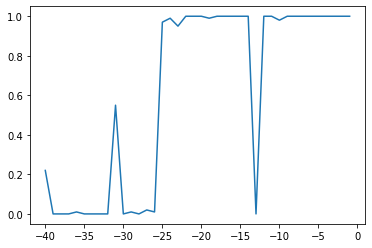

In [4]:
plt.plot(SNRs,np.array(PDs))
plt.show()

In [9]:
total

0.006999999999999999

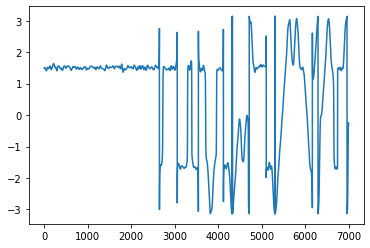

In [24]:
plt.plot(np.angle(Complex[3000:10000]))
plt.show()